## Experiments

Let's start playing around with our data

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import tqdm
from sklearn.model_selection import train_test_split
from datasets import load_dataset,Dataset,DatasetDict
from transformers import DataCollatorWithPadding,AutoModelForSequenceClassification,AutoModel,AutoConfig
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from imblearn.under_sampling import RandomUnderSampler
from torch.optim import Adam, AdamW
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2024-04-29 16:34:29.868579: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 16:34:31.662473: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Read in training data
This dataset contains 100 annotated terms of service contracts, each row represents a sentence, which carries on it a label. The label corresponds to a different type of potential unfairness, as defined by the authors of CLAUDETTE, the previous paper from which this dataset came from.

In [2]:
df = pd.read_csv('../data/dataset.csv')
df.head()

,Unnamed: 0,A,CH,CR,J,LAW,LTD,PINC,TER,USE,document,document_ID,label,text,TER_targets,LTD_targets,A_targets,CH_targets,CR_targets
0,0,0,0,0,0,0,0,0,0,0,Mozilla,0,0,websites & communications terms of use,NaN,NaN,NaN,NaN,NaN
1,1,0,0,0,0,0,0,0,0,0,Mozilla,0,0,please read the terms of this entire document ...,NaN,NaN,NaN,NaN,NaN
2,2,0,0,0,0,0,0,0,0,1,Mozilla,0,1,by accessing or signing up to receive communic...,NaN,NaN,NaN,NaN,NaN
3,3,0,0,0,0,0,0,0,0,0,Mozilla,0,0,our websites include multiple domains such as ...,NaN,NaN,NaN,NaN,NaN
4,4,0,0,0,0,0,0,0,0,0,Mozilla,0,0,you may also recognize our websites by nicknam...,NaN,NaN,NaN,NaN,NaN


# Bag of Words Model

**Preprocessing**

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

texts = df['text'].values
labels = df['label'].values

texts_train, texts_test, labels_train, labels_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

def preprocess(text):
    # tokenize
    tokens = word_tokenize(text)
    # removing stopwords to focus on meaningful vocab
    tokens = [word for word in tokens if word.lower() not in stop_words]
    return tokens

texts_train = [preprocess(text) for text in texts_train]
texts_test = [preprocess(text) for text in texts_test]

[nltk_data] Downloading package stopwords to /home/jonat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jonat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Stemming**

In [4]:
from nltk.stem import PorterStemmer
from nltk.util import ngrams

for column in df.columns:
    df[column] = df[column].fillna('')
    df[column] = df[column].astype(str)

texts = df['text'].astype(str).values
labels = df['label'].values

texts_train, texts_test, labels_train, labels_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# using porterstemmer reduce words to their roots
stemmer = PorterStemmer()

def preprocess(text, n=2):
    # text -> tokens
    tokens = word_tokenize(text)
    # stem and removing stopwords
    tokens = [stemmer.stem(word) for word in tokens if word.lower() not in stop_words and word.isalpha()]
    # n-gram generation
    n_grams = list(ngrams(tokens, n))
    # flattening list of n-grams
    n_grams = ['_'.join(gram) for gram in n_grams]
    return tokens + n_grams

# include n-grams in data processing
texts_train = [preprocess(text, n=2) for text in texts_train]
texts_test = [preprocess(text, n=2) for text in texts_test]

In [5]:
print(texts_test[0:20])

[['ubisoft', 'advis', 'includ', 'surnam', 'user', 'name', 'ubisoft_advis', 'advis_includ', 'includ_surnam', 'surnam_user', 'user_name'], ['agre', 'distribut', 'part', 'part', 'websit', 'servic', 'includ', 'limit', 'content', 'medium', 'without', 'youtub', 'prior', 'written', 'authoris', 'unless', 'youtub', 'make', 'avail', 'mean', 'distribut', 'function', 'offer', 'servic', 'youtub', 'player', 'agre_distribut', 'distribut_part', 'part_part', 'part_websit', 'websit_servic', 'servic_includ', 'includ_limit', 'limit_content', 'content_medium', 'medium_without', 'without_youtub', 'youtub_prior', 'prior_written', 'written_authoris', 'authoris_unless', 'unless_youtub', 'youtub_make', 'make_avail', 'avail_mean', 'mean_distribut', 'distribut_function', 'function_offer', 'offer_servic', 'servic_youtub', 'youtub_player'], ['event', 'member', 'disput', 'one', 'member', 'member', 'herebi', 'releas', 'compani', 'director', 'offic', 'employe', 'agent', 'independ', 'contractor', 'repres', 'parent', 's

BoW Model

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

# init CountVectorizer with 1-2 n-grams (should suffice for our purposes)
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 2), token_pattern=r'\b\w+\b')

# preparing train data by joining tokens into strings (countvectorizor takes in strings)
texts_train_joined = [' '.join(text) for text in texts_train]
texts_test_joined = [' '.join(text) for text in texts_test]

# fitting vectorizer on the train data
X_train = vectorizer.fit_transform(texts_train_joined)

# transforming test data based on fitted vocab
X_test = vectorizer.transform(texts_test_joined)

**Classifier**

In [7]:
print(texts_train_joined[0:20])

['term supersed prior agreement earlier version term evernot use servic effect date indic top term term_supersed supersed_prior prior_agreement agreement_earlier earlier_version version_term term_evernot evernot_use use_servic servic_effect effect_date date_indic indic_top top_term', 'may upload publish post distribut dissemin unauthor privat confidenti person inform other may_upload upload_publish publish_post post_distribut distribut_dissemin dissemin_unauthor unauthor_privat privat_confidenti confidenti_person person_inform inform_other', 'world warcraft requir creation retent electron file includ without limit player charact account statist user profil weapon armor quest loot etc game data store blizzard entertain avoid doubt data concern player use voic client store world_warcraft warcraft_requir requir_creation creation_retent retent_electron electron_file file_includ includ_without without_limit limit_player player_charact charact_account account_statist statist_user user_profil

In [8]:
X_train

<16333x343318 sparse matrix of type '<class 'numpy.int64'>'
	with 851585 stored elements in Compressed Sparse Row format>

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# init/train classifier
classifier = LogisticRegression()
classifier.fit(X_train, labels_train)

# predicting on test set
labels_pred = classifier.predict(X_test)

# getting accuracy
accuracy = accuracy_score(labels_test, labels_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9419686581782566


Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
classifier_2 = LogisticRegression(penalty="elasticnet",solver="saga",max_iter=1000)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'l1_ratio': [0, 0.25, 0.5, 0.75, 1]  # Balance between L1 and L2 regularization
}
grid_search = GridSearchCV(classifier_2, param_grid, cv=5,scoring='f1_macro',verbose=3)
grid_search.fit(X_train, labels_train)
print(f"Best Parameters Found: {grid_search.best_params_}") 
print(f"Best Score Found: {grid_search.best_score_}")

**Classification Report**

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3632
           1       0.84      0.59      0.69       452

    accuracy                           0.94      4084
   macro avg       0.89      0.79      0.83      4084
weighted avg       0.94      0.94      0.94      4084



Text(0.5, 1.0, 'Bag of Words Confusion Matrix')

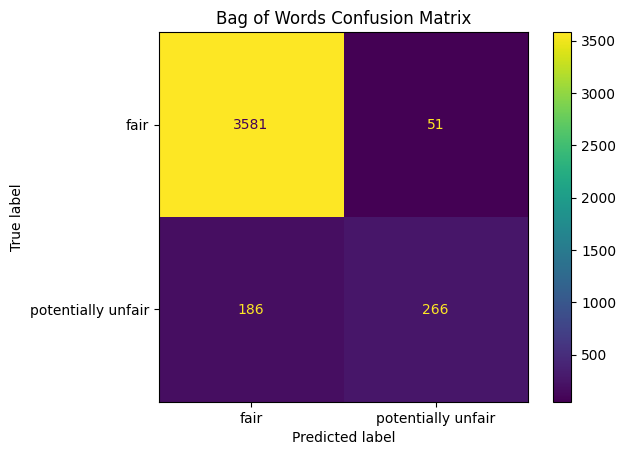

In [14]:
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

# performance analysis
print(classification_report(labels_test, labels_pred))
cm = confusion_matrix(labels_test, labels_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["fair", "potentially unfair"])
disp.plot()
plt.title("Bag of Words Confusion Matrix")

Save and Export the model to run it in our demo

In [16]:
import joblib
joblib.dump(classifier, '../models/logistic_regression_bow.pkl')

['../models/logistic_regression_bow.pkl']

In [24]:
joblib.dump(vectorizer, '../models/bow_count_vectorizer.pkl')

['../models/bow_count_vectorizer.pkl']

In [23]:
bow_classifier = joblib.load('../models/logistic_regression_bow.pkl')
bow_classifier.predict(X_train)

array(['0', '0', '0', ..., '0', '1', '0'], dtype=object)

Text(0.5, 1.0, 'Bag of Words Confusion Matrix (hyperparameter tuned)')

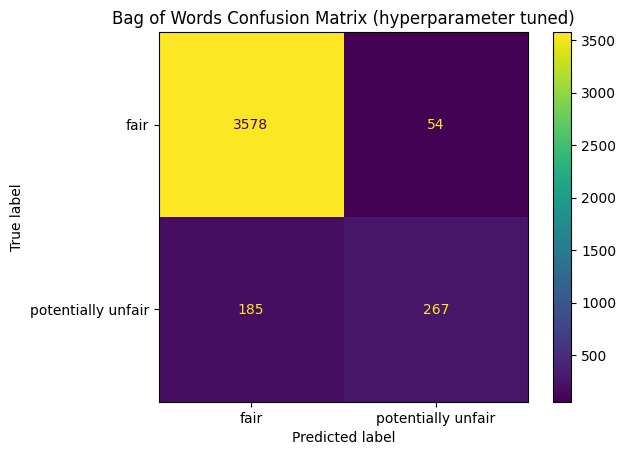

In [35]:
classifier_2 = LogisticRegression(penalty="elasticnet",solver="saga",max_iter=2000,C=1,l1_ratio=0.5)
classifier_2.fit(X_train, labels_train)
labels_pred = classifier_2.predict(X_test)

cm_2 = confusion_matrix(labels_test, labels_pred)
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=["fair", "potentially unfair"])
disp_2.plot()
plt.title("Bag of Words Confusion Matrix (hyperparameter tuned)")

Looks like hyper parameter tuning isn't making much of a difference

Let's see if we can combine the BERT model approach with the bag of words approach. Hopefully this will give us an understanding of the semantic meaning of the text from BERT, along with the better understanding of the actual words themselves from Bag of Words.

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer

class HybridModel(nn.Module):
    def __init__(self, num_bow_features, num_labels):
        super(HybridModel, self).__init__()
        self.bert = BertModel.from_pretrained('distilbert/distilbert-base-uncased')
        self.linear_bow = nn.Linear(num_bow_features, 128)  # Assuming 128 hidden units
        self.classifier = nn.Linear(128 + 768, num_labels)  # 768 is the size of BERT base hidden state
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask, bow_features):
        # BERT encoding
        with torch.no_grad():
            outputs = self.bert(input_ids, attention_mask=attention_mask)
        bert_output = outputs.pooler_output  # Using the pooled output
        # BoW pathway
        bow_output = self.linear_bow(bow_features)
        # Combine the outputs
        combined_output = torch.cat((bert_output, bow_output), dim=1)
        combined_output = self.dropout(combined_output)
        # Classifier
        logits = self.classifier(combined_output)
        return self.softmax(logits)

# Example usage
tokenizer = BertTokenizer.from_pretrained('distilbert/distilbert-base-uncased')
text = "Example text for our model"
encoded_input = tokenizer(text, return_tensors='pt')
bow_text = vectorizer(preprocess(text))
bow_features = torch.rand(1, 500)  # Example BoW vector of size 500

model = HybridModel(num_bow_features=343318, num_labels=2)
output = model(encoded_input['input_ids'], encoded_input['attention_mask'], bow_features)
print(output)


In [12]:
bow_text = vectorizer.transform(preprocess("this is a test"))

In [19]:
logits = classifier.decision_function(bow_text)
logits

NameError: name 'bow_classifier' is not defined

If we want to make an ensemble method, we will have to use tensorflow because it has more support for sparse matrices, which we need for the bag of words method, compared to pytorch